In [1]:
import sys
sys.path.append("../../")

import numpy as np
import matplotlib.pyplot as plt
import lpips
import torch
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
from diffusers.training_utils import free_memory
from accelerate.utils import set_seed

from inversions.unet_based.npi import SDInversionPipeline, SDXLInversionPipeline, CustomDDIMInversionScheduler, image2latents, latents2image
from inversions.utils import pil2tensor


👋 Welcome to use MuLingCloud. We aim to let everything easier.

📍 mlcbase (1.2.11) imported



In [2]:
set_seed(666)

torch_dtype = torch.float16
variant = "fp16"
device = "cuda"
num_inference_steps = 50
lpips_loss = lpips.LPIPS(net='alex')

image_path = "../../demo/alley.jpg"
prompt = "A narrow alley way with a building in the background."

Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


/home/chenwm/.conda/envs/diffusion-inversion/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/chenwm/.conda/envs/diffusion-inversion/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: /home/chenwm/.conda/envs/diffusion-inversion/lib/python3.10/site-packages/lpips/weights/v0.1/alex.pth


## Stable Diffusion v1.5

In [3]:
model_id = "/home/ailab/model_weights/stable-diffusion/stable-diffusion-v1-5/"
scheduler = CustomDDIMInversionScheduler.from_pretrained(model_id, subfolder="scheduler")
pipe = SDInversionPipeline.from_pretrained(model_id, torch_dtype=torch_dtype, variant=variant, scheduler=scheduler)
pipe.to(device)

inv_result = pipe.inverse(
    image=image_path,
    prompt=prompt,
    guidance_scale=0.0,
    num_inference_steps=num_inference_steps
)

ori_image = inv_result.ori_image
vae_latent = image2latents(pipe, ori_image)
vae_recon = latents2image(pipe, vae_latent)

recon_image = pipe(
    prompt=prompt,
    num_inference_steps=num_inference_steps,
    guidance_scale=7.5,
    latents=inv_result.zT
).images[0]

del vae_latent, inv_result, pipe
free_memory()

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

DDIM Inversion: 100%|■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■ 😎 [50/50] 00:00:02 00:00:00



  0%|          | 0/50 [00:00<?, ?it/s]

[VAE Reconstruction] PSNR: 26.97, SSIM: 0.8089, LPIPS: 0.0550
[NPI] PSNR: 22.11, SSIM: 0.7384, LPIPS: 0.1426


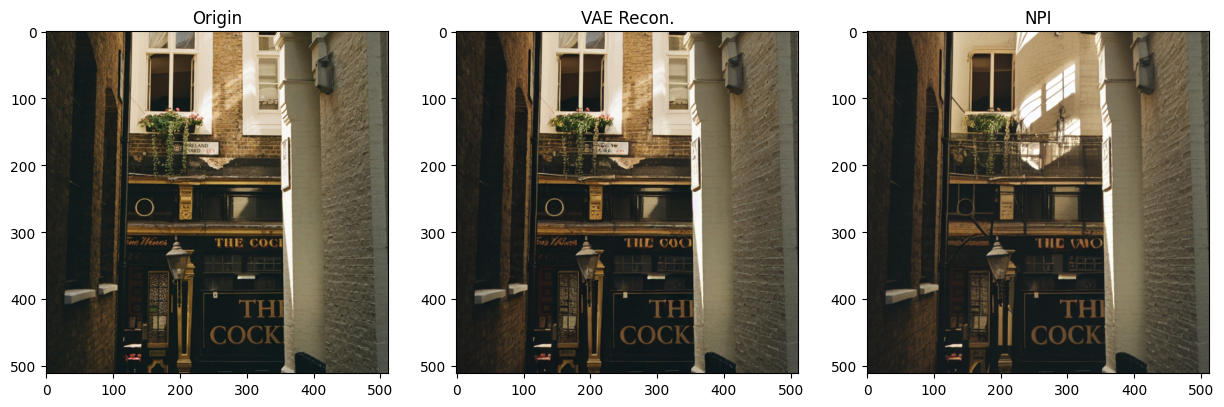

In [4]:
vae_psnr = psnr(np.array(ori_image), np.array(vae_recon))
vae_ssim = ssim(np.array(ori_image), np.array(vae_recon), win_size=11, channel_axis=2)
vae_lpips = lpips_loss(pil2tensor(ori_image), pil2tensor(vae_recon)).item()
print(f"[VAE Reconstruction] PSNR: {vae_psnr:.2f}, SSIM: {vae_ssim:.4f}, LPIPS: {vae_lpips:.4f}")

psnr_score = psnr(np.array(ori_image), np.array(recon_image))
ssim_score = ssim(np.array(ori_image), np.array(recon_image), win_size=11, channel_axis=2)
lpips_score = lpips_loss(pil2tensor(ori_image), pil2tensor(recon_image)).item()
print(f"[NPI] PSNR: {psnr_score:.2f}, SSIM: {ssim_score:.4f}, LPIPS: {lpips_score:.4f}")

fig = plt.figure(figsize=(15, 5))
axs = fig.subplots(1, 3)
axs[0].set_title("Origin")
axs[0].imshow(np.array(ori_image))
axs[1].set_title("VAE Recon.")
axs[1].imshow(np.array(vae_recon))
axs[2].set_title("NPI")
axs[2].imshow(np.array(recon_image))
plt.show()

## Stable Diffusion v2.1

In [5]:
model_id = "/home/ailab/model_weights/stable-diffusion/stable-diffusion-v2-1/"
scheduler = CustomDDIMInversionScheduler.from_pretrained(model_id, subfolder="scheduler")
pipe = SDInversionPipeline.from_pretrained(model_id, torch_dtype=torch_dtype, variant=variant, scheduler=scheduler)
pipe.to(device)

inv_result = pipe.inverse(
    image=image_path,
    prompt=prompt,
    guidance_scale=0.0,
    num_inference_steps=num_inference_steps
)

ori_image = inv_result.ori_image
vae_latent = image2latents(pipe, ori_image)
vae_recon = latents2image(pipe, vae_latent)

recon_image = pipe(
    prompt=prompt,
    num_inference_steps=num_inference_steps,
    guidance_scale=7.5,
    latents=inv_result.zT
).images[0]

del vae_latent, inv_result, pipe
free_memory()

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

DDIM Inversion: 100%|■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■ 😎 [50/50] 00:00:03 00:00:00



  0%|          | 0/50 [00:00<?, ?it/s]

[VAE Reconstruction] PSNR: 28.61, SSIM: 0.8441, LPIPS: 0.0406
[NPI] PSNR: 20.27, SSIM: 0.6135, LPIPS: 0.2690


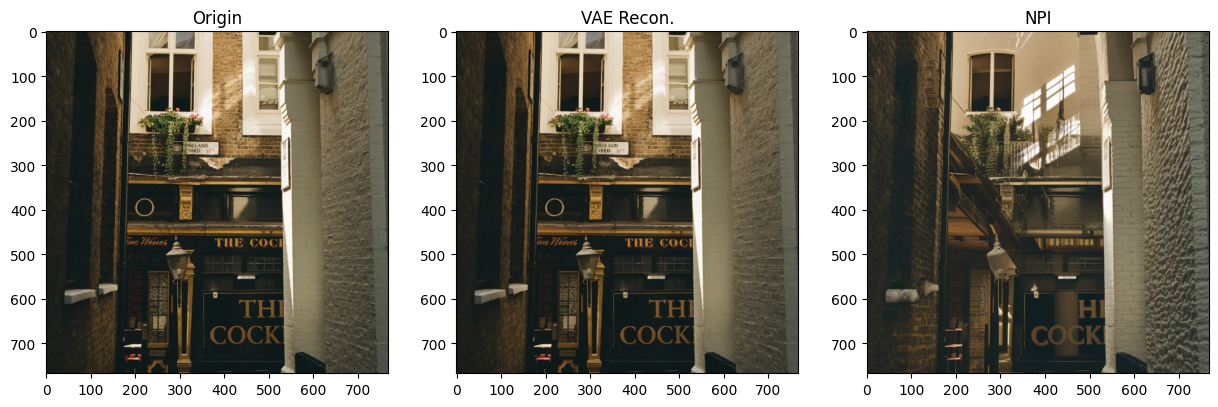

In [6]:
vae_psnr = psnr(np.array(ori_image), np.array(vae_recon))
vae_ssim = ssim(np.array(ori_image), np.array(vae_recon), win_size=11, channel_axis=2)
vae_lpips = lpips_loss(pil2tensor(ori_image), pil2tensor(vae_recon)).item()
print(f"[VAE Reconstruction] PSNR: {vae_psnr:.2f}, SSIM: {vae_ssim:.4f}, LPIPS: {vae_lpips:.4f}")

psnr_score = psnr(np.array(ori_image), np.array(recon_image))
ssim_score = ssim(np.array(ori_image), np.array(recon_image), win_size=11, channel_axis=2)
lpips_score = lpips_loss(pil2tensor(ori_image), pil2tensor(recon_image)).item()
print(f"[NPI] PSNR: {psnr_score:.2f}, SSIM: {ssim_score:.4f}, LPIPS: {lpips_score:.4f}")

fig = plt.figure(figsize=(15, 5))
axs = fig.subplots(1, 3)
axs[0].set_title("Origin")
axs[0].imshow(np.array(ori_image))
axs[1].set_title("VAE Recon.")
axs[1].imshow(np.array(vae_recon))
axs[2].set_title("NPI")
axs[2].imshow(np.array(recon_image))
plt.show()

## SDXL

In [7]:
model_id = "/home/ailab/model_weights/stable-diffusion/sdxl-base-v1.0/"
scheduler = CustomDDIMInversionScheduler.from_pretrained(model_id, subfolder="scheduler")
pipe = SDXLInversionPipeline.from_pretrained(model_id, torch_dtype=torch_dtype, variant=variant, scheduler=scheduler)
pipe.to(device)

inv_result = pipe.inverse(
    image=image_path,
    prompt=prompt,
    guidance_scale=0.0,
    num_inference_steps=num_inference_steps
)

ori_image = inv_result.ori_image
vae_latent = image2latents(pipe, ori_image)
vae_recon = latents2image(pipe, vae_latent)

recon_image = pipe(
    prompt=prompt,
    num_inference_steps=num_inference_steps,
    guidance_scale=5.0,
    latents=inv_result.zT
).images[0]

del vae_latent, inv_result, pipe
free_memory()

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

DDIM Inversion: 100%|■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■ 😎 [50/50] 00:00:08 00:00:00



  0%|          | 0/50 [00:00<?, ?it/s]

[VAE Reconstruction] PSNR: 30.44, SSIM: 0.8745, LPIPS: 0.0397
[DDIM Inversion] PSNR: 25.41, SSIM: 0.7488, LPIPS: 0.2144


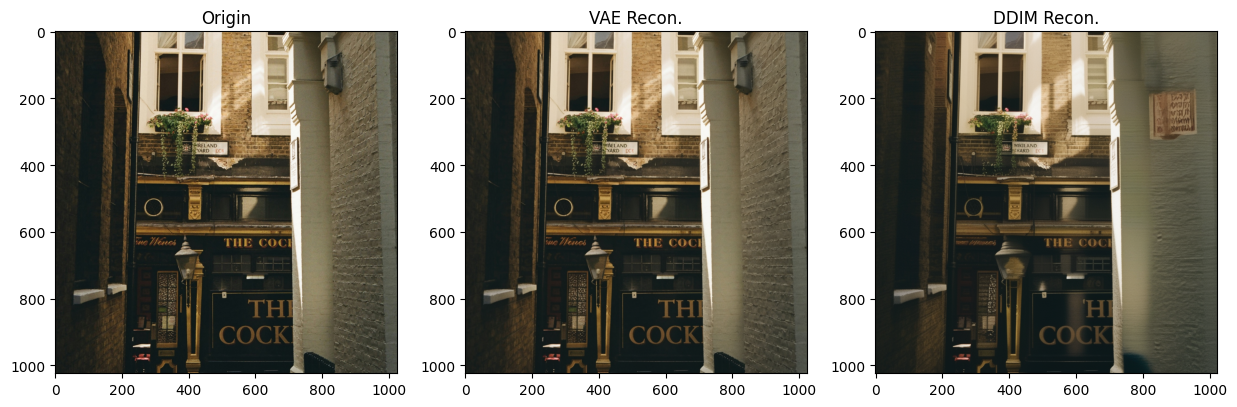

In [8]:
vae_psnr = psnr(np.array(ori_image), np.array(vae_recon))
vae_ssim = ssim(np.array(ori_image), np.array(vae_recon), win_size=11, channel_axis=2)
vae_lpips = lpips_loss(pil2tensor(ori_image), pil2tensor(vae_recon)).item()
print(f"[VAE Reconstruction] PSNR: {vae_psnr:.2f}, SSIM: {vae_ssim:.4f}, LPIPS: {vae_lpips:.4f}")

psnr_score = psnr(np.array(ori_image), np.array(recon_image))
ssim_score = ssim(np.array(ori_image), np.array(recon_image), win_size=11, channel_axis=2)
lpips_score = lpips_loss(pil2tensor(ori_image), pil2tensor(recon_image)).item()
print(f"[DDIM Inversion] PSNR: {psnr_score:.2f}, SSIM: {ssim_score:.4f}, LPIPS: {lpips_score:.4f}")

fig = plt.figure(figsize=(15, 5))
axs = fig.subplots(1, 3)
axs[0].set_title("Origin")
axs[0].imshow(np.array(ori_image))
axs[1].set_title("VAE Recon.")
axs[1].imshow(np.array(vae_recon))
axs[2].set_title("DDIM Recon.")
axs[2].imshow(np.array(recon_image))
plt.show()